# Progetto di Data and Web mining

Matteo Spanio, A.A. 2021/2022

# Modello lineare multivariato

Verifichiamo l'ipotesi di linearità del modello

## Globalmente

In [6]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
import warnings
warnings.filterwarnings("ignore")

df_train = zd.get_train_dataset()
df_validation = zd.get_validation_dataset()

preprocessor = ZillowTransformer()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)
df_validation = preprocessor.transform(df_validation)

# one hot encoding and column type transform
encoder = ZillowEncoder()
encoder.fit(df_train)

df_train = encoder.transform(df_train)
df_validation = encoder.transform(df_validation)

In [7]:
X_train, y_train = zd.split_x_y(df_train)
X_test, y_test = zd.split_x_y(df_validation)

La regressione lineare fornita da sklearn non ha molti parametri su cui fare tuning, proprio per questo vale comunque la pena vedere cosa suggerisce la grid search dal momento che non allunherà di molto i tempi di training

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from Zillow.metrics import print_measure
import pandas as pd

lr = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'positive': [False, True]
}

gscv = GridSearchCV(estimator=lr,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                   )

gscv.fit(X_train, y_train)

pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.827481,0.062989,0.009865,0.002583,True,False,"{'fit_intercept': True, 'positive': False}",-0.068494,-0.069119,-0.068949,-0.069269,-0.067868,-0.068740,0.000508,4
1,2.223144,0.208857,0.006227,0.000823,True,True,"{'fit_intercept': True, 'positive': True}",-0.068524,-0.069171,-0.068888,-0.069053,-0.067675,-0.068662,0.000540,2
2,0.659996,0.066740,0.007711,0.000554,False,False,"{'fit_intercept': False, 'positive': False}",-0.068494,-0.069119,-0.068949,-0.069269,-0.067868,-0.068740,0.000508,3
3,1.307152,0.169273,0.003348,0.000803,False,True,"{'fit_intercept': False, 'positive': True}",-0.068513,-0.069156,-0.068852,-0.069019,-0.067696,-0.068647,0.000522,1


In [10]:
gscv.best_params_

{'fit_intercept': False, 'positive': True}

In [11]:
print_measure(y_true=y_test, y_pred=gscv.predict(X_test))

Mean absolute error: 0.07094
 Mean squared error: 0.02999
           R2 score: 0.00212


Verifichiamo la performance sul dataset di test e allenando il modello su train e validation insieme

In [12]:
import pandas as pd

train, validation, test = zd.get_preprocessed_data()
train = pd.concat([train, validation], axis=0, ignore_index=True)

X_train, y_train = zd.split_x_y(train)
X_test, y_test = zd.split_x_y(test)

In [13]:
lr = LinearRegression(fit_intercept=False, positive=True)

lr.fit(X_train, y_train)

print_measure(y_true=y_test, y_pred=lr.predict(X_test))

Mean absolute error: 0.06987
 Mean squared error: 0.02851
           R2 score: 0.00363


Questo modello ha restituito un *mean absolute error* leggermente migliore rispetto alla predizione basata sulla media ($0.06987 < 0.06998$), anche se si tratta di una significatività sulla quarta cifra decimale.

### Scaling data

Vediamo se scalando i dati migliora qualcosa, dal momento che i dati non hanno una distribuzione normale utilizzo il minmaxscaler

In [14]:
train, validation, test = zd.get_preprocessed_data()
train = pd.concat([train, validation], axis=0, ignore_index=True)

X_train, y_train = zd.split_x_y(train)
X_test, y_test = zd.split_x_y(test)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

lr = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'positive': [False, True]
}

gscv = GridSearchCV(estimator=lr,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=5,
                    n_jobs=-1
                   )

gscv.fit(scaler.transform( X_train ), y_train)
gscv.best_params_

{'fit_intercept': False, 'positive': True}

In [16]:
print_measure(y_true=y_test, y_pred=gscv.predict(scaler.transform( X_test )))

Mean absolute error: 0.06987
 Mean squared error: 0.02853
           R2 score: 0.00305


Il risultato rimane invariato.

## Regressione lineare per county

In [17]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
from Zillow.types import County, Features as ft

import warnings
warnings.filterwarnings("ignore")
# Orange
o_train, o_validation, o_test = zd.get_preprocessed_data(County.ORANGE)

# Ventura
v_train, v_validation, v_test = zd.get_preprocessed_data(County.VENTURA)

# Los Angeles
la_train, la_validation, la_test = zd.get_preprocessed_data(County.LOS_ANGELES)

In [21]:
train = pd.concat([o_train, o_validation], axis=0, ignore_index=True)
X_train_o, y_train_o = zd.split_x_y(train)
X_test_o, y_test_o = zd.split_x_y(o_test)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_o)

lr = LinearRegression(fit_intercept=False, positive=True)

lr.fit( scaler.transform( X_train_o ), y_train_o)

print_measure(y_true=y_test_o, y_pred=lr.predict(scaler.transform(X_test_o)))

Mean absolute error: 0.06256
 Mean squared error: 0.02420
           R2 score: -0.00566


In [23]:
# Ventura
train = pd.concat([v_train, v_validation], axis=0, ignore_index=True)
X_train_v, y_train_v = zd.split_x_y(train)
X_test_v, y_test_v = zd.split_x_y(v_test)

scaler.fit(X_train_v)

lr.fit( scaler.transform(X_train_v), y_train_v)

print_measure(y_true=y_test_v, y_pred=lr.predict(scaler.transform(X_test_v)))

Mean absolute error: 0.06104
 Mean squared error: 0.02844
           R2 score: 0.00611


In [24]:
# LA
train = pd.concat([la_train, la_validation], axis=0, ignore_index=True)
X_train_la, y_train_la = zd.split_x_y(train)
X_test_la, y_test_la = zd.split_x_y(la_test)

scaler.fit(X_train_la)

lr.fit(scaler.transform( X_train_la ), y_train_la)

print_measure(y_true=y_test_la, y_pred=lr.predict(scaler.transform( X_test_la )))

Mean absolute error: 0.07457
 Mean squared error: 0.02906
           R2 score: 0.00288


In [25]:
import numpy as np
np.mean([0.06256, 0.06104, 0.07457])

0.06605666666666667

La regressione lineare per contea performa meglio di quella generale con una significatività di 3 punti sulla terza cifra decimale, ma è un predittore peggiore della media ($0.06226 < 0.06614$)

Text(0.5, 1.0, 'MAE per area with linear regressor')

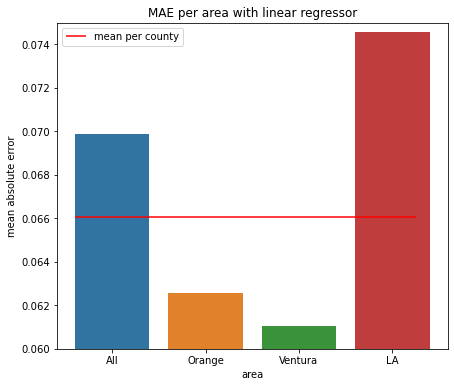

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 6))
data = pd.DataFrame({'score': [0.06987, 0.06256, 0.06104, 0.07457], 'area': ['All', 'Orange', 'Ventura', 'LA']})
sns.barplot(data=data, x='area', y='score', ax=ax)
ax.set_ylim(0.060,0.075);
ax.set_ylabel('mean absolute error')
ax.hlines(0.06605666666666667, xmin=-0.4, xmax=3.25, colors='red', label='mean per county');
ax.legend()
ax.set_title('MAE per area with linear regressor')

# Albero di decisione

Studiamo ora la capacità predittiva di un albero di decisione

## Globalmente

In [26]:
import Zillow.data as zd

train, validation, test = zd.get_preprocessed_data()

X_train, y_train = zd.split_x_y(train)
X_validation, y_validation = zd.split_x_y(validation)

In questo caso si può cercare di trovare i parametri ottimi per l'albero di decisione, per risparmiare un po' di tempo di calcolo il tuning verrà effettuato sul $40\%$ del dataset di train

In [27]:
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42)

len(X_small), len(y_small)

(42972, 42972)

In [35]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

lr = DecisionTreeRegressor()

params = {
    'criterion': ['squared_error'], # 'absolute_error'],
    'splitter': ['random', 'best'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [x for x in range(2, 101)],
    'max_features': ['sqrt', 1.0]
}

gscv = GridSearchCV(estimator=lr,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=4,
                    verbose=1,
                    n_jobs=-1,
                   )

gscv.fit(X_train, y_train)

gscv.best_params_

Fitting 4 folds for each of 4752 candidates, totalling 19008 fits
CPU times: user 33.5 s, sys: 7.35 s, total: 40.9 s
Wall time: 21min 20s


{'criterion': 'squared_error',
 'max_features': 1.0,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'random'}

Ovviamente il modello performa meglio con un numero basso di foglie: all'aumentare del numero di foglie il modello dovrebbe specializzarsi sempre più, andando in overfitting

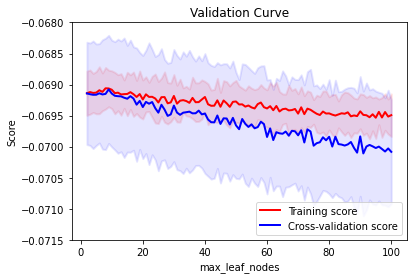

In [46]:
import Zillow.visualization as zv

zv.plot_grid_search_validation_curve(gscv, 'max_leaf_nodes', ylim=(-.0715,-.068))

In [37]:
from Zillow.metrics import print_measure
print_measure(y_true=y_validation, y_pred=gscv.predict(X_validation))

Mean absolute error: 0.07089
 Mean squared error: 0.02983
           R2 score: 0.00772


Verifichiamo la performance allenando il modello sull'intero dataset

In [6]:
from Zillow.metrics import measure_model, print_measure

train, validation, test = zd.get_preprocessed_data()
train = pd.concat([train, validation], axis=0, ignore_index=True)

X_train, y_train = zd.split_x_y(train)
X_test, y_test = zd.split_x_y(test)

errors = []

regressor = DecisionTreeRegressor(splitter='random',
                           min_samples_split=2,
                           min_samples_leaf=10,
                           max_leaf_nodes=9,
                           max_features=1.,
                           random_state=42)

regressor.fit(X_train, y_train)
errors.append(measure_model(y_true=y_test, y_pred=regressor.predict(X_test)))
print_measure(y_true=y_test, y_pred=regressor.predict(X_test))

Mean absolute error: 0.07002
 Mean squared error: 0.02856
           R2 score: 0.00174


CPU times: user 64 ms, sys: 4.02 ms, total: 68 ms
Wall time: 64.1 ms


[Text(0.6923076923076923, 0.9375, 'bathroomcnt <= 3.5709377\nsquared_error = 0.0271391\nsamples = 134287\nvalue = 0.0135875'),
 Text(0.5384615384615384, 0.8125, 'structuretaxvaluedollarcnt <= 2121076.6391448\nsquared_error = 0.0254296\nsamples = 124095\nvalue = 0.0122914'),
 Text(0.46153846153846156, 0.6875, 'structuretaxvaluedollarcnt_was_nan <= 0.2024705\nsquared_error = 0.0252001\nsamples = 124077\nvalue = 0.0122275'),
 Text(0.38461538461538464, 0.5625, 'taxdelinquencyflag <= 0.8063771\nsquared_error = 0.0250518\nsamples = 123706\nvalue = 0.0123871'),
 Text(0.3076923076923077, 0.4375, 'calculatedfinishedsquarefeet <= 2648.6824657\nsquared_error = 0.0245417\nsamples = 120280\nvalue = 0.0119145'),
 Text(0.23076923076923078, 0.3125, 'calculatedfinishedsquarefeet <= 407.1958592\nsquared_error = 0.0235418\nsamples = 111329\nvalue = 0.010983'),
 Text(0.15384615384615385, 0.1875, 'x1_Thursday <= 0.952642\nsquared_error = 0.3116536\nsamples = 84\nvalue = 0.1649495'),
 Text(0.076923076923076

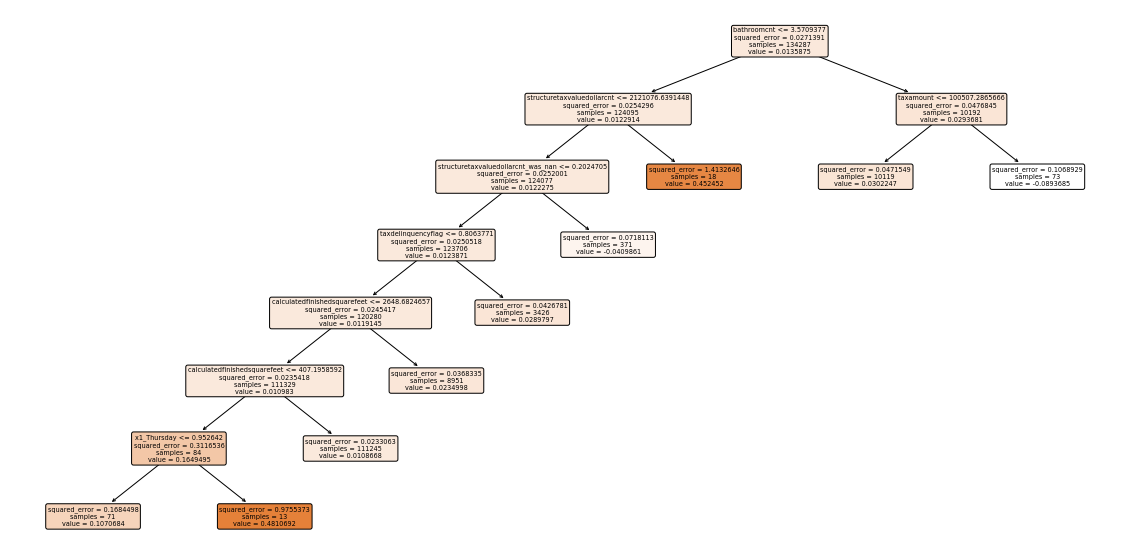

In [9]:
%%time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,10))
plot_tree(regressor, ax=ax,
          precision=7,
          feature_names=X_train.columns.to_list(),
          filled=True, rounded=True);

## Albero di decisione per contea

Si assume che l'ottimo trovato con il GridSearch per il modello generico sia lo stesso per le tre county (che in realtà hanno feature diverse, sarebbe quindi utile rieseguire una ricerca dei parametri ottimali)

In [10]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer, ZillowEncoder
from Zillow.types import County, Features as ft

import warnings
warnings.filterwarnings("ignore")
# Orange
o_train, o_validation, o_test = zd.get_preprocessed_data(County.ORANGE)

# Ventura
v_train, v_validation, v_test = zd.get_preprocessed_data(County.VENTURA)

# Los Angeles
la_train, la_validation, la_test = zd.get_preprocessed_data(County.LOS_ANGELES)

In [12]:
train = pd.concat([o_train, o_validation], axis=0, ignore_index=True)
X_train_o, y_train_o = zd.split_x_y(train)
X_test_o, y_test_o = zd.split_x_y(o_test)

In [13]:
from sklearn.tree import DecisionTreeRegressor
from Zillow.metrics import measure_model

regressor = DecisionTreeRegressor(splitter='random',
                           min_samples_split=2,
                           min_samples_leaf=10,
                           max_leaf_nodes=9,
                           max_features=1.,
                           random_state=42)

train = pd.concat([o_train, o_validation], axis=0, ignore_index=True)
X_train_o, y_train_o = zd.split_x_y(train)

regressor.fit( X_train_o, y_train_o)
print('Orange')
errors.append(measure_model(y_true=y_test_o, y_pred=regressor.predict(X_test_o)))
print_measure(y_true=y_test_o, y_pred=regressor.predict(X_test_o))

Orange
Mean absolute error: 0.06262
 Mean squared error: 0.02425
           R2 score: -0.00756


In [14]:
# Ventura
train = pd.concat([v_train, v_validation], axis=0, ignore_index=True)
X_train_v, y_train_v = zd.split_x_y(train)
X_test_v, y_test_v = zd.split_x_y(v_test)

regressor.fit( X_train_v, y_train_v)
print('Ventura')
errors.append(measure_model(y_true=y_test_v, y_pred=regressor.predict(X_test_v)))
print_measure(y_true=y_test_v, y_pred=regressor.predict(X_test_v))

Ventura
Mean absolute error: 0.06101
 Mean squared error: 0.02852
           R2 score: 0.00333


In [15]:
# LA
train = pd.concat([la_train, la_validation], axis=0, ignore_index=True)
X_train_la, y_train_la = zd.split_x_y(train)
X_test_la, y_test_la = zd.split_x_y(la_test)

regressor.fit( X_train_la, y_train_la)
print('LA')
errors.append(measure_model(y_true=y_test_la, y_pred=regressor.predict(X_test_la)))
print_measure(y_true=y_test_la, y_pred=regressor.predict(X_test_la))

LA
Mean absolute error: 0.07475
 Mean squared error: 0.02904
           R2 score: 0.00361


In [17]:
import numpy as np
np.mean([e[0] for e in errors])

0.06709834316780826

Text(0.5, 1.0, 'MAE per area with dicision tree')

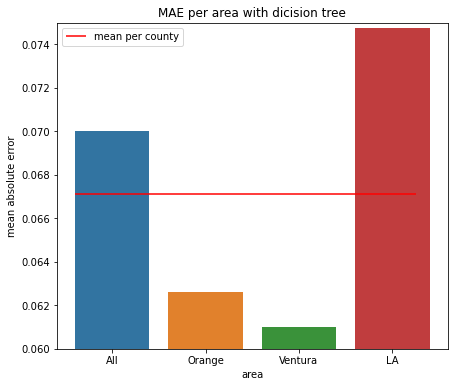

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
data = pd.DataFrame({'score': [0.07002, 0.06262, 0.06101, 0.07475], 'area': ['All', 'Orange', 'Ventura', 'LA']})
sns.barplot(data=data, x='area', y='score', ax=ax)
ax.set_ylim(0.060,0.075);
ax.set_ylabel('mean absolute error')
ax.hlines(0.06709834316780826, xmin=-0.4, xmax=3.25, colors='red', label='mean per county');
ax.legend()
ax.set_title('MAE per area with dicision tree')